# Deep Generative Models - Autoencoders and GANs

See the related medium article: **Celebrity and Anime Image Generation with GANs and Autoencoders**

Link to article: https://medium.com/@matthew_stewart/comprehensive-introduction-to-turing-learning-and-gans-part-2-fd8e4a70775

**May 2019**
**Author:** Matthew Stewart

This notebook contains the implementation of several deep generative models using variational autoencoders (VAEs), generative adversarial networks (GANs), and also the implementation of a VAE-GAN. A VAE-GAN is a hybrid type of GAN where the generator is actually itself a variational autoencoder. 

To increase the visual quality of samples, it is encouraged to try out some tricks from the extra reading material or from other articles online, such as switching to Wasserstein GANs (WGANs), applying label smoothing, expanding and regularizing the architecture or trying pretraining.

It should be noted that this notebook is not aimed at optimizing the performance of a GAN, which is a very time-consuming and laborious process. If one wishes to obtain images of a higher quality, it is recommended that one has access to high performance computing resources such as a cluster with GPUs in order to speed up performance. Running this notebook using a standard computer will likely take an entire day on a standard MacBook Pro.

I hope you enjoy this notebook and find it useful and informative.

# Part 1: Making Faces

We'll be using a subset of the Celeb A dataset to help us build facial generative models.  As described [on the Celeb A site](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

> CelebFaces Attributes Dataset (CelebA) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter. CelebA has large diversities, large quantities, and rich annotations, including

> - 10,177 number of identities,
> - 202,599 number of face images, and
> - 5 landmark locations, 40 binary attributes annotations per image.

### Part A: Preparing the Data

In the provided data you'll see the `img_align_celeba` directory. The images in that directory will form your dataset.  You may want to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

In [1]:
import shutil
import errno
import zipfile
import os
import matplotlib.pyplot as plt

In [7]:
# Only run once to unzip images
zip_ref = zipfile.ZipFile('img_align_celeba.zip','r')
zip_ref.extractall()
zip_ref.close()

**Create a custom image generator.**</span>

In [2]:
# data generator
# source from https://medium.com/@ensembledme/writing-custom-keras-generators-fe815d992c5a
from skimage.io import imread

def get_input(path):
    """get specific image from path"""
    img = imread(path)
    return img

def get_output(path, label_file = None):
    """get all the labels relative to the image of path"""
    img_id = path.split('/')[-1]
    labels = label_file.loc[img_id].values
    return labels

def preprocess_input(img):
    # convert between 0 and 1
    return img.astype('float32') / 127.5 -1

def image_generator(files, label_file, batch_size = 32):
    while True:

        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:

            input = get_input(input_path)
            input = preprocess_input(input)
            output = get_output(input_path, label_file = label_file)
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

def auto_encoder_generator(files, batch_size = 32):
    while True:
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        for input_path in batch_paths:
            input = get_input(input_path)
            input = preprocess_input(input)
            output = input
            batch_input += [input]
            batch_output += [output]
        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        yield batch_x, batch_y

**Load the attribute data.**</span>

In [3]:
# now load attribute
import pandas as pd
attr = pd.read_csv('list_attr_celeba.csv')
attr = attr.set_index('image_id')

# check if attribute successful loaded
attr.describe()

5_o_Clock_Shadow  Arched_Eyebrows    Attractive  Bags_Under_Eyes  \
count     202599.000000    202599.000000  202599.00000    202599.000000   
mean          -0.777728        -0.466039       0.02501        -0.590857   
std            0.628602         0.884766       0.99969         0.806778   
min           -1.000000        -1.000000      -1.00000        -1.000000   
25%           -1.000000        -1.000000      -1.00000        -1.000000   
50%           -1.000000        -1.000000       1.00000        -1.000000   
75%           -1.000000         1.000000       1.00000        -1.000000   
max            1.000000         1.000000       1.00000         1.000000   

                Bald          Bangs       Big_Lips       Big_Nose  \
count  202599.000000  202599.000000  202599.000000  202599.000000   
mean       -0.955113      -0.696849      -0.518408      -0.530935   
std         0.296241       0.717219       0.855135       0.847414   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%        -1.000000      -1.000000      -1.000000      -1.000000   
75%        -1.000000      -1.000000      -1.000000      -1.000000   
max         1.000000       1.000000       1.000000       1.000000   

          Black_Hair     Blond_Hair      ...            Sideburns  \
count  202599.000000  202599.000000      ...        202599.000000   
mean       -0.521498      -0.704016      ...            -0.886979   
std         0.853255       0.710186      ...             0.461811   
min        -1.000000      -1.000000      ...            -1.000000   
25%        -1.000000      -1.000000      ...            -1.000000   
50%        -1.000000      -1.000000      ...            -1.000000   
75%        -1.000000      -1.000000      ...            -1.000000   
max         1.000000       1.000000      ...             1.000000   

             Smiling  Straight_Hair      Wavy_Hair  Wearing_Earrings  \
count  202599.000000  202599.000000  202599.000000      202599.00000   
mean       -0.035839      -0.583196      -0.360866          -0.62215   
std         0.999360       0.812333       0.932620           0.78290   
min        -1.000000      -1.000000      -1.000000          -1.00000   
25%        -1.000000      -1.000000      -1.000000          -1.00000   
50%        -1.000000      -1.000000      -1.000000          -1.00000   
75%         1.000000      -1.000000       1.000000          -1.00000   
max         1.000000       1.000000       1.000000           1.00000   

         Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
count  202599.000000     202599.000000     202599.000000    202599.000000   
mean       -0.903079         -0.055129         -0.754066        -0.854570   
std         0.429475          0.998482          0.656800         0.519338   
min        -1.000000         -1.000000         -1.000000        -1.000000   
25%        -1.000000         -1.000000         -1.000000        -1.000000   
50%        -1.000000         -1.000000         -1.000000        -1.000000   
75%        -1.000000          1.000000         -1.000000        -1.000000   
max         1.000000          1.000000          1.000000         1.000000   

               Young  
count  202599.000000  
mean        0.547234  
std         0.836982  
min        -1.000000  
25%         1.000000  
50%         1.000000  
75%         1.000000  
max         1.000000  

[8 rows x 40 columns]

**Finish making the generator.**</span>

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split

IMG_NAME_LENGTH = 6

file_path = "img_align_celeba/"
img_id = np.arange(1,len(attr.index)+1)
img_path = []
for i in range(len(img_id)):
    img_path.append(file_path + (IMG_NAME_LENGTH - len(str(img_id[i])))*'0' + str(img_id[i]) + '.jpg')

# pick 80% as training set and 20% as validation set
train_path = img_path[:int((0.8)*len(img_path))]
val_path = img_path[int((0.8)*len(img_path)):]

train_generator = auto_encoder_generator(train_path,32)
val_generator = auto_encoder_generator(val_path,32)


**Pick three images and check that attributes make sense.**</span>

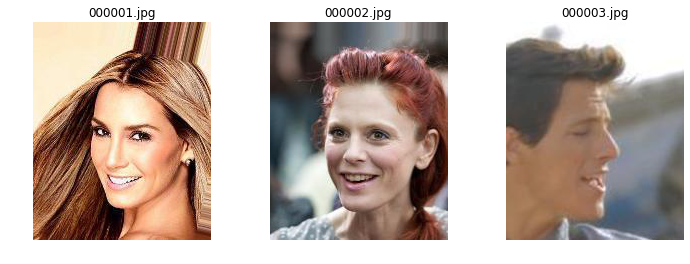

5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
image_id                                                                     
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...    \
image_id                                                             ...     
000001.jpg    -1     -1        -1        -1          -1          -1  ...     
000002.jpg    -1     -1        -1         1          -1          -1  ...     
000003.jpg    -1     -1         1        -1          -1          -1  ...     

            Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
image_id                                                                     
000001.jpg         -1        1              1         -1                 1   
000002.jpg         -1        1             -1         -1                -1   
000003.jpg         -1       -1             -1          1                -1   

            Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  \
image_id                                                                       
000001.jpg           -1                 1                -1               -1   
000002.jpg           -1                -1                -1               -1   
000003.jpg           -1                -1                -1               -1   

            Young  
image_id           
000001.jpg      1  
000002.jpg      1  
000003.jpg      1  

[3 rows x 40 columns]

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for i in range(3):    
    ax[i].imshow(get_input(img_path[i]))
    ax[i].axis('off')
    ax[i].set_title(img_path[i][-10:])
plt.show()
    
attr.iloc[:3]

### Part B: Building and Training a Variational Autoencoder Model

In this section we will create and compile a Convolutional Variational Autoencoder Model (including encoder and decoder) for the celebrity faces dataset.  It is good practice to print summaries for the encoder, decoder and full autoencoder models in order to check the architecture of the network. We will then train the model on the images in the celeba dataset.

In [6]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Input, Reshape, UpSampling2D, InputLayer, Lambda, ZeroPadding2D, Cropping2D, Conv2DTranspose, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.losses import binary_crossentropy
from keras import backend as K,objectives
from keras.losses import mse, binary_crossentropy

Using TensorFlow backend.


In [7]:
img_sample = get_input(img_path[0])
img_sample.shape

(218, 178, 3)

**Create and make a summary of the model.**</span>

In [9]:
b_size = 128
n_size = 512
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape = (n_size,) , mean = 0, stddev = 1)
    return z_mean + K.exp(z_log_sigma/2) * epsilon
  
def build_conv_vae(input_shape, bottleneck_size, sampling, batch_size = 32):
    
    # ENCODER
    input = Input(shape=(input_shape[0],input_shape[1],input_shape[2]))
    x = Conv2D(32,(3,3),activation = 'relu', padding = 'same')(input)    
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(64,(3,3),activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    x = Conv2D(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding ='same')(x)
    
    # Latent Variable Calculation
    shape = K.int_shape(x)
    flatten_1 = Flatten()(x)
    dense_1 = Dense(bottleneck_size, name='z_mean')(flatten_1)
    z_mean = BatchNormalization()(dense_1)
    flatten_2 = Flatten()(x)
    dense_2 = Dense(bottleneck_size, name ='z_log_sigma')(flatten_2)
    z_log_sigma = BatchNormalization()(dense_2)
    z = Lambda(sampling)([z_mean, z_log_sigma])
    encoder = Model(input, [z_mean, z_log_sigma, z], name = 'encoder')
    
    # DECODER
    latent_input = Input(shape=(bottleneck_size,), name = 'decoder_input')
    x = Dense(shape[1]*shape[2]*shape[3])(latent_input)
    x = Reshape((shape[1],shape[2],shape[3]))(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,0],[0,1]])(x)
    x = Conv2DTranspose(256,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(128,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Cropping2D([[0,1],[0,1]])(x)
    x = Conv2DTranspose(64,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32,(3,3), activation = 'relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    output = Conv2DTranspose(3,(3,3), activation = 'tanh', padding ='same')(x)
    decoder = Model(latent_input, output, name = 'decoder')

    output_2 = decoder(encoder(input)[2])
    vae = Model(input, output_2, name ='vae')
    return vae, encoder, decoder, z_mean, z_log_sigma

vae_2, encoder, decoder, z_mean, z_log_sigma = build_conv_vae(img_sample.shape, n_size, sampling, batch_size = b_size)
print("encoder summary:")
encoder.summary()
print("decoder summary:")
decoder.summary()
print("vae summary:")
vae_2.summary()

encoder summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 218, 178, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 218, 178, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 218, 178, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 109, 89, 32)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [10]:
def vae_loss(input_img, output):
    # Compute error in reconstruction
    reconstruction_loss = mse(K.flatten(input_img) , K.flatten(output))
    
    # Compute the KL Divergence regularization term
    kl_loss = - 0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = -1)
    
    # Return the average loss over all images in batch
    total_loss = (reconstruction_loss + 0.0001 * kl_loss)    
    return total_loss

In [11]:
vae_2.compile(optimizer='rmsprop', loss= vae_loss)
encoder.compile(optimizer = 'rmsprop', loss = vae_loss)
decoder.compile(optimizer = 'rmsprop', loss = vae_loss)

**Train the model.  Note that each epoch will take awhile (perhaps ~45 min per epoch to train).**</span>

In [ ]:
vae_2.fit_generator(train_generator, steps_per_epoch = 4000, validation_data = val_generator, epochs=7, validation_steps= 500)

Epoch 1/15
4000/4000 [==============================] - 2778s 694ms/step - loss: 0.0947 - val_loss: 0.0760
Epoch 2/15
4000/4000 [==============================] - 2770s 692ms/step - loss: 0.0741 - val_loss: 0.0730
Epoch 3/15
4000/4000 [==============================] - 2766s 692ms/step - loss: 0.0695 - val_loss: 0.0685
Epoch 4/15
4000/4000 [==============================] - 2778s 694ms/step - loss: 0.0666 - val_loss: 0.0685
Epoch 5/15
4000/4000 [==============================] - 2781s 695ms/step - loss: 0.0646 - val_loss: 0.0699
Epoch 6/15
4000/4000 [==============================] - 2776s 694ms/step - loss: 0.0633 - val_loss: 0.0670
Epoch 7/15
  35/4000 [..............................] - ETA: 44:02 - loss: 0.0622

**We randomly choose some images of the training set, run them through the encoder to parameterize the latent code, and then reconstruct the images with the decoder.**</span>

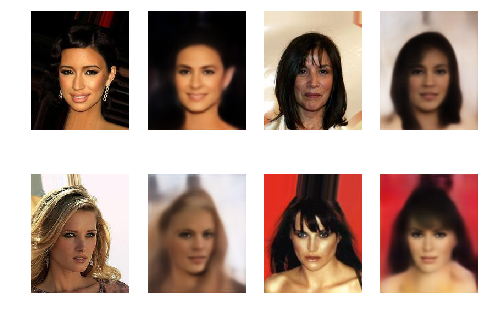

In [21]:
import random
x_test = []
for i in range(64):
    x_test.append(get_input(img_path[random.randint(0,len(img_id))]))
x_test = np.array(x_test)
figure_Decoded = vae_2.predict(x_test.astype('float32')/127.5 -1, batch_size = b_size)
figure_original = x_test[0]
figure_decoded = (figure_Decoded[0]+1)/2
for i in range(4):
    plt.axis('off')
    plt.subplot(2,4,1+i*2)
    plt.imshow(x_test[i])
    plt.axis('off')
    plt.subplot(2,4,2 + i*2)
    plt.imshow((figure_Decoded[i]+1)/2)
    plt.axis('off')
plt.show()  

Notice that the reconstructed images share similarities with the original versions.  However, the new images are a bit blurry, which is a known phenomenon of VAEs.  This has been hypothesized to be due to the fact that variational inference optimizes a lower bound to the likelihood, not the actual likelihood itself.</span>

We choose two images with different attributes and plot their latent space representations.  Notice that we can see some differences between the latent codes, which we might hypothesize as explaining the differences between the original images.</span>

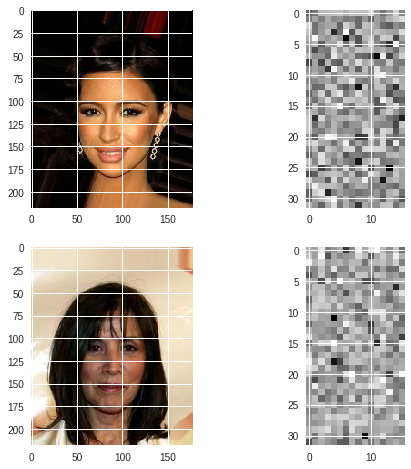

In [22]:
# Choose two images of different attributes, and plot the original and latent space of it

x_test1 = []
for i in range(64):
    x_test1.append(get_input(img_path[np.random.randint(0,len(img_id))]))
x_test1 = np.array(x_test)
x_test_encoded = np.array(encoder.predict(x_test1/127.5-1, batch_size = b_size))
figure_original_1 = x_test[0]
figure_original_2 = x_test[1]
Encoded1 = (x_test_encoded[0,0,:].reshape(32, 16,)+1)/2 
Encoded2 = (x_test_encoded[0,1,:].reshape(32, 16)+1)/2

plt.figure(figsize=(8, 8))
plt.subplot(2,2,1)
plt.imshow(figure_original_1)
plt.subplot(2,2,2)
plt.imshow(Encoded1)
plt.subplot(2,2,3)
plt.imshow(figure_original_2)
plt.subplot(2,2,4)
plt.imshow(Encoded2)
plt.show()

We randomly sample 15 latent codes and decode them to generate new celebrity faces.  We can see from this representation that the images generated by our model are of similar styles with the training images, they are also realistic and have a good variation, meaning we are not suffering from modal collapse.</span>

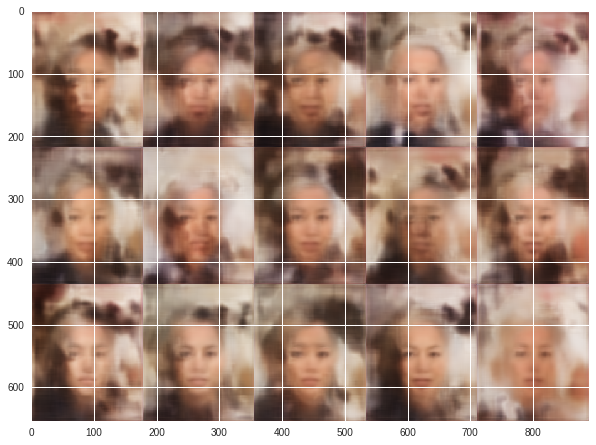

In [23]:
# We randomly generated 15 images from 15 series of noise information

n = 3
m = 5
digit_size1 = 218
digit_size2 = 178
figure = np.zeros((digit_size1 * n, digit_size2 * m,3))
 
for i in range(3):
    for j in range(5):
        z_sample = np.random.rand(1,512)
        x_decoded = decoder.predict([z_sample])
        figure[i * digit_size1: (i + 1) * digit_size1,
               j * digit_size2: (j + 1) * digit_size2,:] = (x_decoded[0]+1)/2 

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

### Part C: Building and Training a DCGAN Model

We can now build a convolutional GAN on the same data and compare this to our above variational autoencoder.

**Create and compile a DC-GAN model, and print the summary.**</span>

In [ ]:
# Create and compile a DC-GAN model, and print the summary

from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, LeakyReLU,\
      BatchNormalization, Conv2DTranspose, Conv2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from scipy.misc import imresize

def generator_model(latent_dim=100, leaky_alpha=0.2, init_stddev=0.02):

    g = Sequential()
    g.add(Dense(4*4*512, input_shape=(latent_dim,),
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Reshape(target_shape=(4, 4, 512)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(256, kernel_size=5, strides=2, padding='same',
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(BatchNormalization())
    g.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    g.add(Conv2DTranspose(3, kernel_size=4, strides=2, padding='same', 
                kernel_initializer=RandomNormal(stddev=init_stddev)))
    g.add(Activation('tanh'))
    g.summary()
    #g.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])
    return g

  
def discriminator_model(leaky_alpha=0.2, init_stddev=0.02):
    
    d = Sequential()
    d.add(Conv2D(64, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev),
               input_shape=(32, 32, 3)))
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(128, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Conv2D(256, kernel_size=5, strides=2, padding='same', 
               kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(BatchNormalization())
    d.add(Activation(LeakyReLU(alpha=leaky_alpha)))
    d.add(Flatten())
    d.add(Dense(1, kernel_initializer=RandomNormal(stddev=init_stddev)))
    d.add(Activation('sigmoid'))
    d.summary()
    return d

def DCGAN(sample_size=100):
    # Generator
    g = generator_model(sample_size, 0.2, 0.02)

    # Discriminator
    d = discriminator_model(0.2, 0.02)
    d.compile(optimizer=Adam(lr=0.001, beta_1=0.5), loss='binary_crossentropy')
    d.trainable = False
    # GAN
    gan = Sequential([g, d])
    gan.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss='binary_crossentropy')
    
    return gan, g, d

In [ ]:
def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    # crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    # resize
    img = imresize(img, size)
    return img

def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255)

def make_labels(size):
    return np.ones([size, 1]), np.zeros([size, 1])  

def show_losses(losses):
    losses = np.array(losses)
    
    fig, ax = plt.subplots()
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Validation Losses")
    plt.legend()
    plt.show()

def show_images(generated_images):
    n_images = len(generated_images)
    cols = 5
    rows = n_images//cols
    
    plt.figure(figsize=(8, 6))
    for i in range(n_images):
        img = deprocess(generated_images[i])
        ax = plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

**Train the model.  We plot 15 generated images every epoch.**</span>

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_9 (Activation)    (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 8, 8, 256)         3277056   
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
activation_10 (Activation)   (None, 8, 8, 256)         0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


Instructions for updating:
Use tf.cast instead.

Epoch:   1/3 Discriminator Loss: 1.1399 Generator Loss: 1.2161


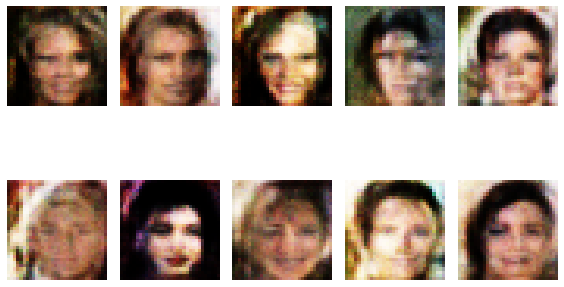

--------------- Epoch 2 ---------------



Epoch:   2/3 Discriminator Loss: 0.5639 Generator Loss: 1.9150


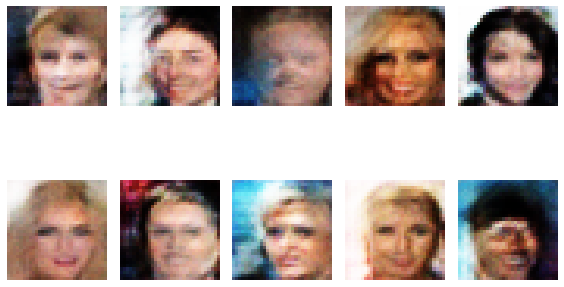

--------------- Epoch 3 ---------------



Epoch:   3/3 Discriminator Loss: 0.8408 Generator Loss: 2.2568


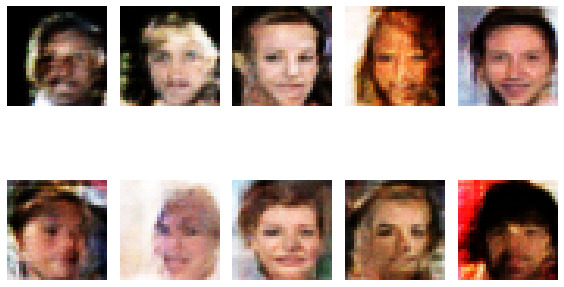

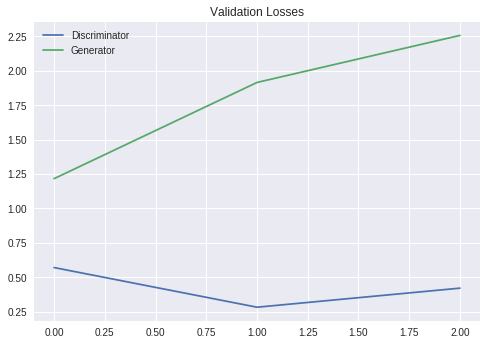

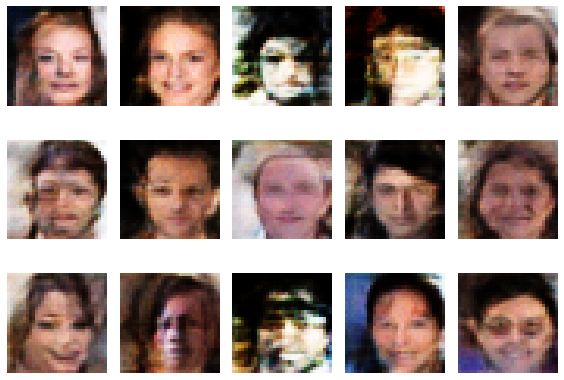

In [ ]:
def train(sample_size=100, epochs=3, batch_size=128, eval_size=16, smooth=0.1):

    batchCount=len(train_path)//batch_size
    y_train_real, y_train_fake = make_labels(batch_size)
    y_eval_real,  y_eval_fake  = make_labels(eval_size)

    
    # create a GAN, a generator and a discriminator
    gan, g, d = DCGAN(sample_size)
    
    losses = []

    for e in range(epochs):
        print('-'*15, 'Epoch %d' % (e+1), '-'*15)
        for i in tqdm_notebook(range(batchCount)):
            
            path_batch = train_path[i*batch_size:(i+1)*batch_size]
            image_batch = np.array([preprocess(load_image(filename)) for filename in path_batch])
            
            noise = np.random.normal(0, 1, size=(batch_size, noise_dim))
            generated_images = g.predict_on_batch(noise)

            # Train discriminator on generated images
            d.trainable = True
            d.train_on_batch(image_batch, y_train_real*(1-smooth))
            d.train_on_batch(generated_images, y_train_fake)

            # Train generator
            d.trainable = False
            g_loss=gan.train_on_batch(noise, y_train_real)
        
        # evaluate
        test_path = np.array(val_path)[np.random.choice(len(val_path), eval_size, replace=False)]
        x_eval_real = np.array([preprocess(load_image(filename)) for filename in test_path])

        noise = np.random.normal(loc=0, scale=1, size=(eval_size, sample_size))
        x_eval_fake = g.predict_on_batch(noise)
        
        d_loss  = d.test_on_batch(x_eval_real, y_eval_real)
        d_loss += d.test_on_batch(x_eval_fake, y_eval_fake)
        g_loss  = gan.test_on_batch(noise, y_eval_real)
        
        losses.append((d_loss/2, g_loss))
  
        print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(
            e+1, epochs, d_loss, g_loss))  
        
        show_images(x_eval_fake[:10])
    
    # show the result
    show_losses(losses)
    show_images(g.predict(np.random.normal(loc=0, scale=1, size=(15, sample_size))))    
    return g
    

noise_dim=100
train()

The generated images look reasonable.  Here we can see that our model performed adequately, though the quality of images is not so good as those in the training set (since we reshaped the images to become smaller and made them more blurry than the orginal ones).  However, they are vivid enough to create valid faces, and these faces are close enough to reality.  Also, compared with images produced by VAE, the images are arguably more creative and realistic.</span>

# Part 2:  VAE-GANIME

Wikipedia describes [Anime]() as follows:

> Anime is hand-drawn and computer animation originating from or associated with Japan.  

> The word anime is the Japanese term for animation, which means all forms of animated media.Outside Japan, anime refers specifically to animation from Japan or as a Japanese-disseminated animation style often characterized by colorful graphics, vibrant characters and fantastical themes. The culturally abstract approach to the word's meaning may open up the possibility of anime produced in countries other than Japan For simplicity, many Westerners strictly view anime as a Japanese animation product. Some scholars suggest defining anime as specifically or quintessentially Japanese may be related to a new form of Orientalism

Here we will use a dataset of anime faces with the aim of creating a model to generate faces in the same style using a special form of GAN, a VAE-GAN.  The term VAE-GAN was first used by Larsen et. al in their paper [“Autoencoding beyond pixels using a learned similarity metric”](https://arxiv.org/abs/1512.09300).  VAE-GAN models differentiate themselves from GANs in that their generators are variation autoencoders.

![](https://cdn-images-1.medium.com/max/800/0*KEmfTtghsCDu6UTb.png)

### Part A: Preparing the Data

We have over 20K anime faces in the form of 64x64 images.  Use them to create your anime face dataset.  You may find it to your advantage to create a [Keras Custom Data Generator](https://techblog.appnexus.com/a-keras-multithreaded-dataframe-generator-for-millions-of-image-files-84d3027f6f43).

**Create anime directory and download online (or from AWS if still accessible)**

In [ ]:
# Create anime directory and download from AWS

import zipfile
!mkdir anime-faces && wget https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip
with zipfile.ZipFile("anime-faces.zip","r") as anime_ref:
    anime_ref.extractall("anime-faces/")

--2019-03-23 19:30:59--  https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.129.109
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.129.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 230757845 (220M) [application/zip]
Saving to: ‘anime-faces.zip’

anime-faces.zip     100%[===================>] 220.07M  35.0MB/s    in 6.8s    

2019-03-23 19:31:06 (32.3 MB/s) - ‘anime-faces.zip’ saved [230757845/230757845]



In [ ]:
from skimage import io
import matplotlib.pyplot as plt

filePath='anime-faces/data/'
imgSets=[]

for i in range(1,20001):
    imgName=filePath+str(i)+'.png'
    imgSets.append(io.imread(imgName))

plt.imshow(imgSets[1234])
plt.axis('off')
plt.show()

### Part B: Building and Training a DCGAN

Initially we will build a standard convolutional GAN so that we can compare it with the VAE-GAN.

**Create and compile a DC-GAN model**

In [ ]:
# Create and compile a DC-GAN model

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, \
    Flatten, LeakyReLU, BatchNormalization, Conv2DTranspose, Conv2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import Adam, RMSprop,SGD
from keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
from tqdm import tqdm_notebook


image_shape = (64, 64, 3)
#noise_shape = (100,)
Noise_dim = 128
img_rows = 64
img_cols = 64
channels = 3

def generator_model(latent_dim=100, leaky_alpha=0.2):
    model = Sequential()
    
    # layer1 (None,500)>>(None,128*16*16)
    model.add(Dense(128 * 16 * 16, activation="relu", input_shape=(Noise_dim,)))
    
    # (None,16*16*128)>>(None,16,16,128)
    model.add(Reshape((16, 16, 128)))
    
   # (None,16,16,128)>>(None,32,32,128)
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    #(None,32,32,128)>>(None,64,64,128)
    model.add(UpSampling2D())
    
    # (None,64,64,128)>>(None,64,64,64)
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    # (None,64,64,128)>>(None,64,64,32)

    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    
    # (None,64,64,32)>>(None,64,64,3)
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])
    return model


def discriminator_model(leaky_alpha=0.2, dropRate=0.3):
    model = Sequential()
    
    # layer1 (None,64,64,3)>>(None,32,32,32)
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, padding="same"))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dropout(dropRate))

    # layer2 (None,32,32,32)>>(None,16,16,64)
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))

    # model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=leaky_alpha))
    model.add(Dropout(dropRate))

    # (None,16,16,64)>>(None,8,8,128)
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropRate))

    # (None,8,8,128)>>(None,8,8,256)
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropRate))

     # (None,8,8,256)>>(None,8,8,64)
    model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(dropRate))
    
    # (None,8,8,64)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    sgd=SGD(lr=0.0002)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])
    return model


def DCGAN(sample_size=Noise_dim):
    # generator
    g = generator_model(sample_size, 0.2)

    # discriminator
    d = discriminator_model(0.2)
    d.trainable = False
    # GAN
    gan = Sequential([g, d])
    
    sgd=SGD()
    gan.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss='binary_crossentropy')
    return gan, g, d


def get_image(image_path, width, height, mode):
    image = Image.open(image_path)
    #print(image.size)

    return np.array(image.convert(mode))


def get_batch(image_files, width, height, mode):
    data_batch = np.array([get_image(sample_file, width, height, mode) \
                           for sample_file in image_files])
    return data_batch


def show_imgs(generator,epoch):
    row=3
    col = 5
    noise = np.random.normal(0, 1, (row * col, Noise_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(row, col)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0

    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1

    #plt.close()
    plt.show()

There are many ways of training the DC-GAN. Here two methods were used, one where the discriminator and generator were trained with the same training times, and another where they were trained with different training times.

#### Method No. 1

We trained the discriminator and generator with the 1:1 proportion of training times

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32768)             4227072   
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 256)       0         
_________________________________________________________________
up_s

Instructions for updating:
Use tf.cast instead.



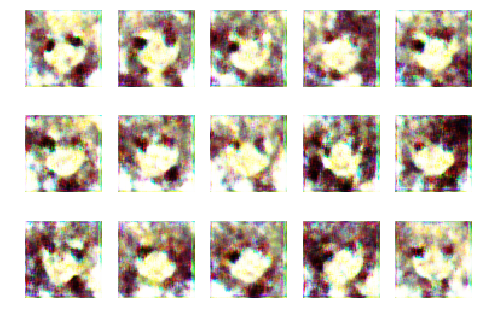

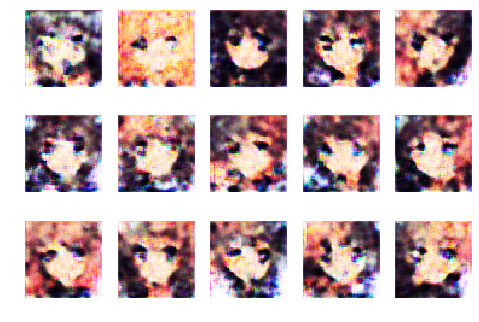

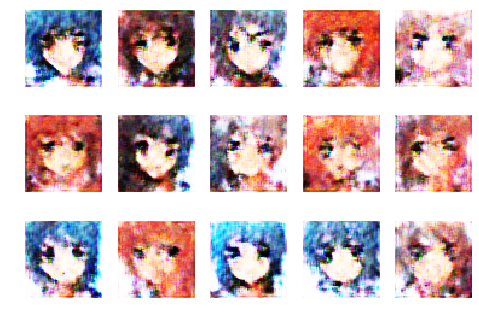

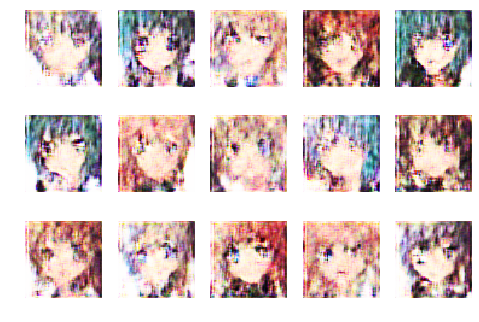

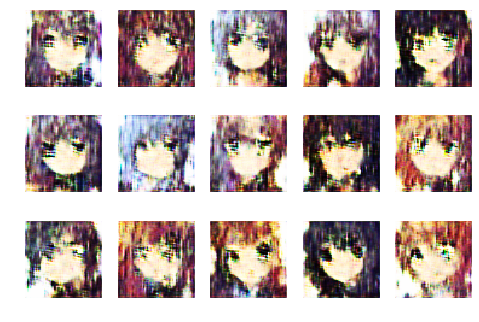

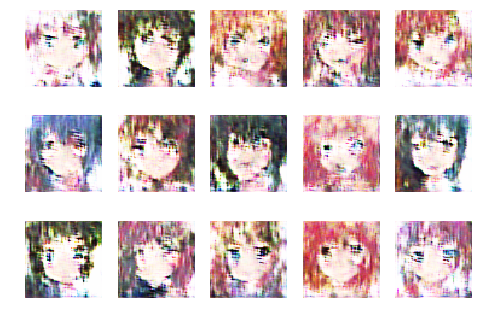

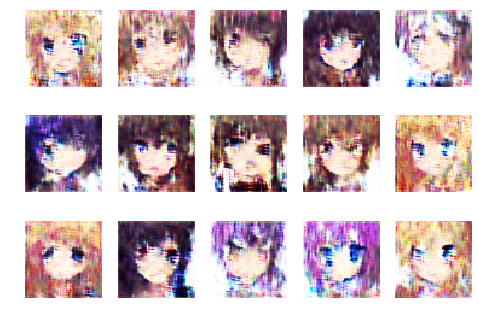

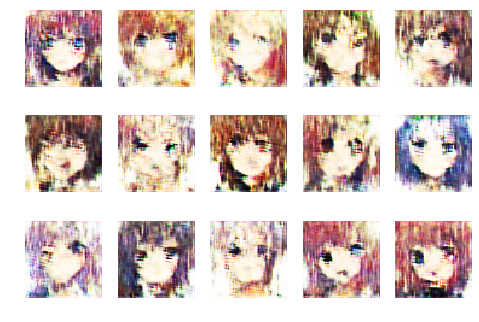

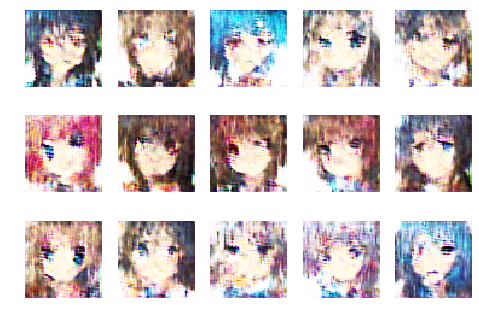

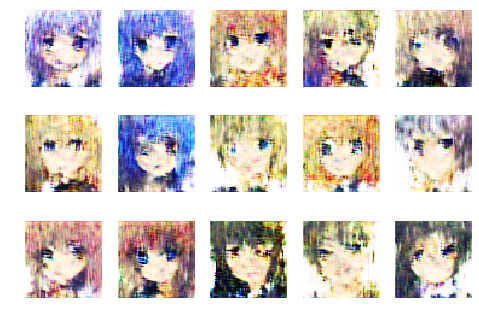

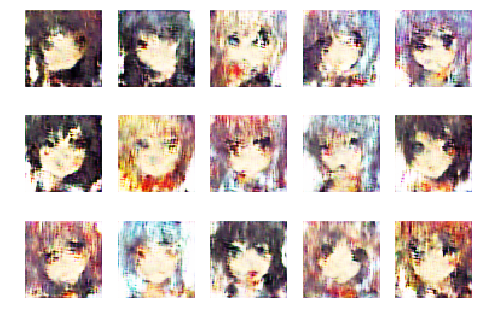

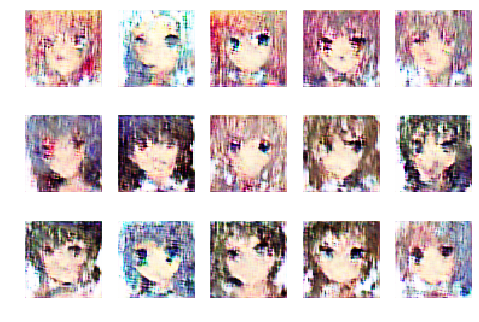

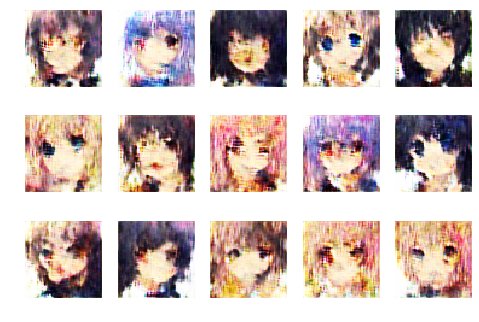

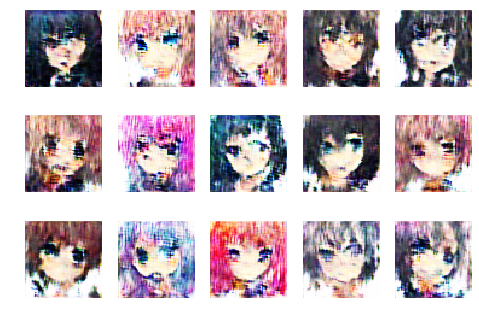

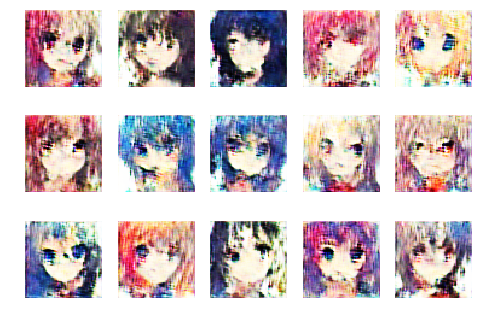

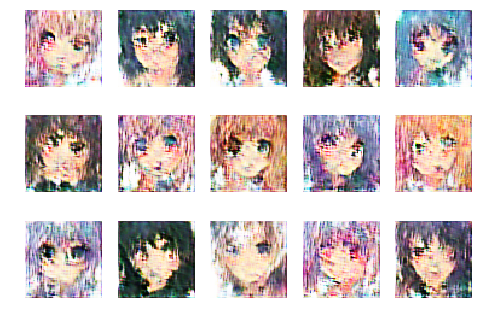

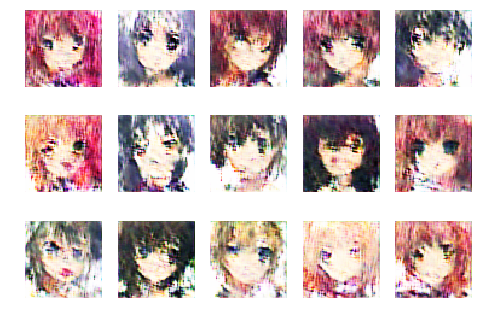

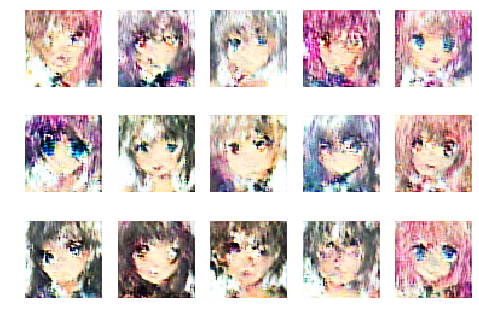

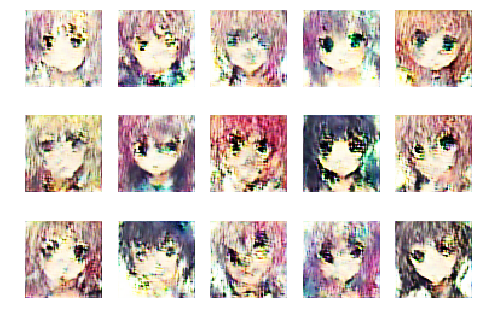

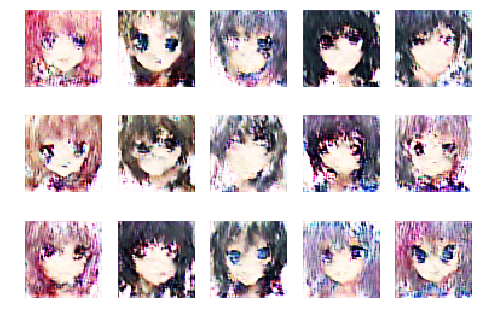

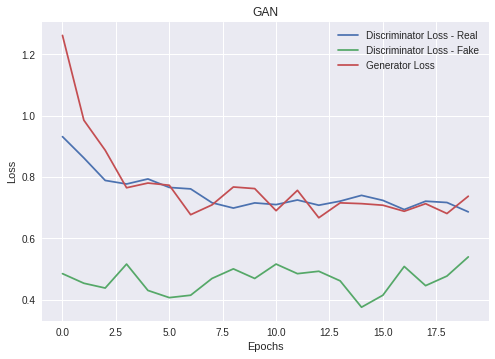

TypeError: ignored

In [ ]:
# We trained the discriminator and generator with the 1:1 proportion of training times

def train(epochs=30, batchSize=128):
    filePath = r'anime-faces/data/'

    X_train = get_batch(glob.glob(os.path.join(filePath, '*.png'))[:20000], 64, 64, 'RGB')
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    halfSize = int(batchSize / 2)
    batchCount=int(len(X_train)/batchSize)

    dLossReal = []
    dLossFake = []
    gLossLogs = []

    gan, generator, discriminator = DCGAN(Noise_dim)

    for e in range(epochs):
        for i in tqdm_notebook(range(batchCount)):
            index = np.random.randint(0, X_train.shape[0], halfSize)
            images = X_train[index]

            noise = np.random.normal(0, 1, (halfSize, Noise_dim))
            genImages = generator.predict(noise)

            # one-sided labels
            discriminator.trainable = True
            dLossR = discriminator.train_on_batch(images, np.ones([halfSize, 1]))
            dLossF = discriminator.train_on_batch(genImages, np.zeros([halfSize, 1]))
            dLoss = np.add(dLossF, dLossR) * 0.5
            discriminator.trainable = False

            noise = np.random.normal(0, 1, (batchSize, Noise_dim))
            gLoss = gan.train_on_batch(noise, np.ones([batchSize, 1]))

        dLossReal.append([e, dLoss[0]])
        dLossFake.append([e, dLoss[1]])
        gLossLogs.append([e, gLoss])

        dLossRealArr = np.array(dLossReal)
        dLossFakeArr = np.array(dLossFake)
        gLossLogsArr = np.array(gLossLogs)
            

        # At the end of training plot the losses vs epochs
        show_imgs(generator, e)

    plt.plot(dLossRealArr[:, 0], dLossRealArr[:, 1], label="Discriminator Loss - Real")
    plt.plot(dLossFakeArr[:, 0], dLossFakeArr[:, 1], label="Discriminator Loss - Fake")
    plt.plot(gLossLogsArr[:, 0], gLossLogsArr[:, 1], label="Generator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN')
    plt.grid(True)
    plt.show()
    
    
    return gan, generator, discriminator


GAN,Generator,Discriminator=train(epochs=20, batchSize=128)  
train(epochs=1000, batchSize=128, plotInternal=200)    

#### Method No. 2

Train the discriminator and generator separately and with different training times

In [ ]:
# Train the discriminator and generator separately and with different training times

def train(epochs=300, batchSize=128, plotInternal=50):
    gLoss = 1
    filePath = r'anime-faces/data/'
    
    X_train = get_batch(glob.glob(os.path.join(filePath,'*.png'))[:20000],64,64,'RGB')
    X_train=(X_train.astype(np.float32)-127.5)/127.5
    halfSize= int (batchSize/2)

    dLossReal=[]
    dLossFake=[]
    gLossLogs=[]
    

    

    for e in range(epochs):
        index=np.random.randint(0,X_train.shape[0],halfSize)
        images=X_train[index]

        noise=np.random.normal(0,1,(halfSize,Noise_dim))
        genImages=generator.predict(noise)
        
        if e < int(epochs*0.5):    
            #one-sided labels
            discriminator.trainable=True
            dLossR=discriminator.train_on_batch(images,np.ones([halfSize,1]))
            dLossF=discriminator.train_on_batch(genImages,np.zeros([halfSize,1]))
            dLoss=np.add(dLossF,dLossR)*0.5
            discriminator.trainable=False

            cnt = e

            while cnt > 3:
                cnt = cnt - 4

            if cnt == 0:
                noise=np.random.normal(0,1,(batchSize,Noise_dim))
                gLoss=gan.train_on_batch(noise,np.ones([batchSize,1]))
                
        elif e>= int(epochs*0.5) :
            cnt = e

            while cnt > 3:
                cnt = cnt - 4

            if cnt == 0:
                #one-sided labels
                discriminator.trainable=True
                dLossR=discriminator.train_on_batch(images,np.ones([halfSize,1]))
                dLossF=discriminator.train_on_batch(genImages,np.zeros([halfSize,1]))
                dLoss=np.add(dLossF,dLossR)*0.5
                discriminator.trainable=False

            
            noise=np.random.normal(0,1,(batchSize,Noise_dim))
            gLoss=gan.train_on_batch(noise,np.ones([batchSize,1]))

        if e % 20 == 0:
           print("epoch： %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, dLoss[0], 100 * dLoss[1], gLoss))

        dLossReal.append([e,dLoss[0]])
        dLossFake.append([e,dLoss[1]])
        gLossLogs.append([e,gLoss])

        if e % plotInternal == 0 and e!=0:
            show_imgs(generator, e)
            
            
        dLossRealArr= np.array(dLossReal)
        dLossFakeArr = np.array(dLossFake)
        gLossLogsArr = np.array(gLossLogs)
        
        chk = e

        while chk > 50:
            chk = chk - 51

        if chk == 0:
            discriminator.save_weights('/content/gdrive/My Drive/discriminator_DCGAN_lr=0.0001,proportion2,deepgenerator_Fake.h5')
            gan.save_weights('/content/gdrive/My Drive/gan_DCGAN_lr=0.0001,proportion2,deepgenerator_Fake.h5')
            generator.save_weights('/content/gdrive/My Drive/generator_DCGAN_lr=0.0001,proportion2,deepgenerator_Fake.h5')
        # At the end of training plot the losses vs epochs
    plt.plot(dLossRealArr[:, 0], dLossRealArr[:, 1], label="Discriminator Loss - Real")
    plt.plot(dLossFakeArr[:, 0], dLossFakeArr[:, 1], label="Discriminator Loss - Fake")
    plt.plot(gLossLogsArr[:, 0], gLossLogsArr[:, 1], label="Generator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('GAN')
    plt.grid(True)
    plt.show()
    
    
    return gan, generator, discriminator

gan, generator, discriminator = DCGAN(Noise_dim)
train(epochs=4000, batchSize=128, plotInternal=200)    


#### Plot the images of method NO.1

Here are the generated pictures.

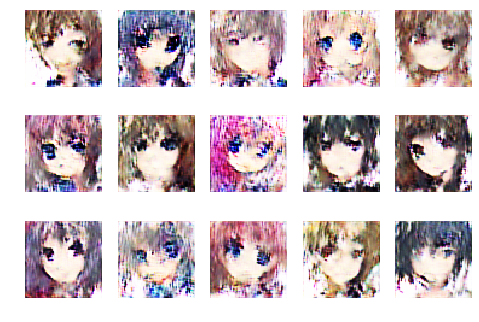

In [ ]:
show_imgs(Generator)

Here are the original images.

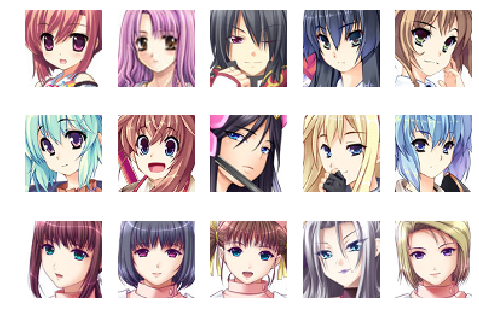

In [ ]:
fig, axs = plt.subplots(row, col)
cnt = 0

row , col =3,5
for i in range(row):
        for j in range(col):
            axs[i, j].imshow(imgSets[cnt])
            axs[i, j].axis('off')
            cnt+=1
plt.show()

#### Plot the images of method NO.2

In [ ]:
discriminator.load_weights('/content/gdrive/My Drive/discriminator_DCGAN_lr0.0001_deepgenerator+proportion2.h5')
gan.load_weights('/content/gdrive/My Drive/gan_DCGAN_lr0.0001_deepgenerator+proportion2.h5')
generator.load_weights('/content/gdrive/My Drive/generator_DCGAN_lr0.0001_deepgenerator+proportion2.h5')

Here are the images generated by the model.

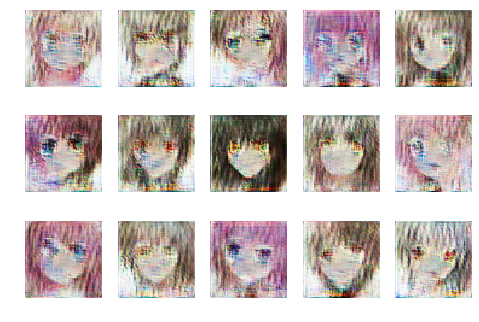

In [ ]:
show_imgs(generator)

We can see that the details of the generated images are improved and their textures are also more detailed.

### Part C: Building and Training a VAE-GAN

Try to import data from google drive

In [ ]:
# try to import data from google drive

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import zipfile
!mkdir anime-faces && wget https://s3.amazonaws.com/gec-harvard-dl2-hw2-data/datasets/anime-faces.zip
with zipfile.ZipFile("anime-faces.zip","r") as anime_ref:
  anime_ref.extractall("anime-faces/")

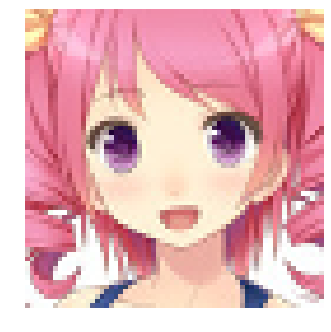

In [ ]:
from skimage import io
import matplotlib.pyplot as plt

filePath='anime-faces/data/'
imgSets=[]

for i in range(1,20001):
    imgName=filePath+str(i)+'.png'
    imgSets.append(io.imread(imgName))

# print (len(imgSets))

plt.imshow(imgSets[12321])
plt.axis('off')
plt.show()


**Create and compile a VAE-GAN, and make a summary for them.**

In [ ]:
# Create and compile a VAE-GAN, and make a summary for them

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, \
    Flatten, LeakyReLU, BatchNormalization, Conv2DTranspose, Conv2D, Reshape,MaxPooling2D,UpSampling2D,InputLayer, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import Adam, RMSprop,SGD
from keras.initializers import RandomNormal
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from PIL import Image
import pandas as pd
from scipy.stats import norm
import keras
from keras.utils import np_utils, to_categorical
from keras import backend as K
import random
from keras import metrics
from tqdm import tqdm


# plotInternal
plotInternal = 50

#######
latent_dim = 256
batch_size = 256
rows = 64
columns = 64
channel = 3
epochs = 4000
# datasize = len(dataset)

# optimizers
SGDop = SGD(lr=0.0003)
ADAMop = Adam(lr=0.0002)
# filters
filter_of_dis = 16
filter_of_decgen = 16
filter_of_encoder = 16


def sampling(args):
    mean, logsigma = args
    epsilon = K.random_normal(shape=(K.shape(mean)[0], latent_dim), mean=0., stddev=1.0)
    return mean + K.exp(logsigma / 2) * epsilon

def vae_loss(X , output , E_mean, E_logsigma):
	# compute the average MSE error, then scale it up, ie. simply sum on all axes
  reconstruction_loss = 2 * metrics.mse(K.flatten(X), K.flatten(output))
  
	# compute the KL loss
  kl_loss = - 0.5 * K.sum(1 + E_logsigma - K.square(E_mean) - K.exp(E_logsigma), axis=-1) 

  total_loss = K.mean(reconstruction_loss + kl_loss)    
  
  return total_loss
  

def encoder(kernel, filter, rows, columns, channel):
    X = Input(shape=(rows, columns, channel))
    model = Conv2D(filters=filter, kernel_size=kernel, strides=2, padding='same')(X)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Flatten()(model)

    mean = Dense(latent_dim)(model)
    logsigma = Dense(latent_dim, activation='tanh')(model)
    latent = Lambda(sampling, output_shape=(latent_dim,))([mean, logsigma])
    meansigma = Model([X], [mean, logsigma, latent])
    meansigma.compile(optimizer=SGDop, loss='mse')
    return meansigma


def decgen(kernel, filter, rows, columns, channel):
    X = Input(shape=(latent_dim,))

    model = Dense(2*2*256)(X)
    model = Reshape((2, 2, 256))(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)
    
    model = Conv2DTranspose(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=filter, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = Activation('relu')(model)

    model = Conv2DTranspose(filters=channel, kernel_size=kernel, strides=2, padding='same')(model)
    model = Activation('tanh')(model)

    model = Model(X, model)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, beta_1=0.5), metrics=['accuracy'])
    return model


def discriminator(kernel, filter, rows, columns, channel):
    X = Input(shape=(rows, columns, channel))

    model = Conv2D(filters=filter*2, kernel_size=kernel, strides=2, padding='same')(X)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*4, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)
    model = BatchNormalization(epsilon=1e-5)(model)
    model = LeakyReLU(alpha=0.2)(model)

    model = Conv2D(filters=filter*8, kernel_size=kernel, strides=2, padding='same')(model)


    dec = BatchNormalization(epsilon=1e-5)(model)
    dec = LeakyReLU(alpha=0.2)(dec)
    dec = Flatten()(dec)
    dec = Dense(1, activation='sigmoid')(dec)

    output = Model(X, dec)
    output.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
                   
    return output

  
def VAEGAN(decgen,discriminator):
    # generator
    g = decgen

    # discriminator
    d = discriminator
    d.trainable = False
    # GAN
    gan = Sequential([g, d])
    
#     sgd=SGD()
    gan.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss='binary_crossentropy')
    return g, d, gan

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
def get_image(image_path, width, height, mode):
    image = Image.open(image_path)
    #print(image.size)

    return np.array(image.convert(mode))



def show_imgs(generator):
    row=3
    col = 5
    noise = np.random.normal(0, 1, (row*col, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(row, col)
    #fig.suptitle("DCGAN: Generated digits", fontsize=12)
    cnt = 0

    for i in range(row):
        for j in range(col):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1

    #plt.close()
    plt.show()

Note: The parameters of generator will be affected by both the gan and VAE training.

In [ ]:
# note: The parameters of generator will be effected by both the gan and VAE training


G, D, GAN = VAEGAN(decgen(5, filter_of_decgen, rows, columns, channel),discriminator(5, filter_of_dis, rows, columns, channel))

# encoder
E = encoder(5, filter_of_encoder, rows, columns, channel)
print("This is the summary for encoder:")
E.summary()


# generator/decoder
# G = decgen(5, filter_of_decgen, rows, columns, channel)
print("This is the summary for dencoder/generator:")
G.summary()


# discriminator
# D = discriminator(5, filter_of_dis, rows, columns, channel)
print("This is the summary for discriminator:")
D.summary()


D_fixed = discriminator(5, filter_of_dis, rows, columns, channel)
D_fixed.compile(optimizer=SGDop, loss='mse')

# gan
print("This is the summary for GAN:")
GAN.summary()

# VAE
X = Input(shape=(rows, columns, channel))

E_mean, E_logsigma, Z = E(X)


output = G(Z)
# G_dec = G(E_mean + E_logsigma)
# D_fake, F_fake = D(output)
# D_fromGen, F_fromGen = D(G_dec)
# D_true, F_true = D(X)

# print("type(E)",type(E))
# print("type(output)",type(output))
# print("type(D_fake)",type(D_fake))

VAE = Model(X, output)
VAE.add_loss(vae_loss(X, output, E_mean, E_logsigma))
VAE.compile(optimizer=SGDop)

print("This is the summary for vae:")
VAE.summary()

This is the summary for encoder:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 32, 32, 16)   1216        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 32, 32, 16)   64          conv2d_5[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_5 (LeakyReLU)       (None, 32, 32, 16)   0           batch_normalization_9[0][0]      
____________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


This is the summary for GAN:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 64, 64, 3)         1354595   
_________________________________________________________________
model_2 (Model)              (None, 1)                 671681    
Total params: 2,026,276
Trainable params: 1,353,603
Non-trainable params: 672,673
_________________________________________________________________
This is the summary for vae:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
model_3 (Model)              [(None, 256), (None, 256) 1320288   
_________________________________________________________________
model_1 (Model)              (None, 64, 64, 3)         1354595   
To

In [ ]:
D.load_weights('/content/gdrive/My Drive/VAE discriminator_kernalsize5_proportion_32.h5')
G.load_weights('/content/gdrive/My Drive/VAE generator_kernalsize5_proportion_32.h5')
E.load_weights('/content/gdrive/My Drive/VAE encoder_kernalsize5_proportion_32.h5')

In [ ]:
imgSets1 = np.array(imgSets)
dataset = (imgSets1.astype(np.float32)-127.5)/127.5
# print(len(dataset),dataset)

We train our model in this cell.
**Note:** I used the method to train the discriminator and VAE-GAN for different times. I emphasize the training of discriminator in the first half of the training process in order to get a good discriminator, however, we train the generator more in the second half because we want to improve the quality of output images.

In [ ]:
# We train our model in this cell

dLoss=[]
gLoss=[]
GLoss = 1
GlossEnc = 1
GlossGen = 1
Eloss = 1

halfbatch_size = int(batch_size*0.5)

for epoch in tqdm(range(epochs)):
    if epoch < int(epochs*0.5):
        noise = np.random.normal(0, 1, (halfbatch_size, latent_dim))
        index = np.random.randint(0,dataset.shape[0], halfbatch_size)
        images = dataset[index]  

        latent_vect = E.predict(images)[0]
        encImg = G.predict(latent_vect)
        fakeImg = G.predict(noise)

        D.Trainable = True
        DlossTrue = D.train_on_batch(images, np.ones((halfbatch_size, 1)))
        DlossEnc = D.train_on_batch(encImg, np.ones((halfbatch_size, 1)))       # 分别试试有和没有这个D的训练效果怎么样
        DlossFake = D.train_on_batch(fakeImg, np.zeros((halfbatch_size, 1)))

#         DLoss=np.add(DlossTrue,DlossFake)*0.5
        
        DLoss=np.add(DlossTrue,DlossEnc)
        DLoss=np.add(DLoss,DlossFake)*0.33
        D.Trainable = False

        cnt = epoch

        while cnt > 3:
            cnt = cnt - 4

        if cnt == 0:
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            index = np.random.randint(0,dataset.shape[0], batch_size)
            images = dataset[index]  
            latent_vect = E.predict(images)[0]     
            
            GlossEnc = GAN.train_on_batch(latent_vect, np.ones((batch_size, 1)))
            GlossGen = GAN.train_on_batch(noise, np.ones((batch_size, 1)))
            Eloss = VAE.train_on_batch(images, None)   
            GLoss=np.add(GlossEnc,GlossGen)
            GLoss=np.add(GLoss,Eloss)*0.33
        dLoss.append([epoch,DLoss[0]]) 
        gLoss.append([epoch,GLoss])
    
    
    
    elif epoch >= int(epochs*0.5):
        cnt = epoch
        while cnt > 3:
            cnt = cnt - 4

        if cnt == 0:
            noise = np.random.normal(0, 1, (halfbatch_size, latent_dim))
            index = np.random.randint(0,dataset.shape[0], halfbatch_size)
            images = dataset[index]  

            latent_vect = E.predict(images)[0]
            encImg = G.predict(latent_vect)
            fakeImg = G.predict(noise)

            D.Trainable = True
            DlossTrue = D.train_on_batch(images, np.ones((halfbatch_size, 1)))
        #     DlossEnc = D.train_on_batch(encImg, np.ones((halfbatch_size, 1)))       # 分别试试有和没有这个D的训练效果怎么样
            DlossFake = D.train_on_batch(fakeImg, np.zeros((halfbatch_size, 1)))

            DLoss=np.add(DlossTrue,DlossFake)*0.5
        
#             DLoss=np.add(DlossTrue,DlossEnc)
#             DLoss=np.add(DLoss,DlossFake)*0.33
            D.Trainable = False

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        index = np.random.randint(0,dataset.shape[0], batch_size)
        images = dataset[index]  
        latent_vect = E.predict(images)[0]
        
        GlossEnc = GAN.train_on_batch(latent_vect, np.ones((batch_size, 1)))
        GlossGen = GAN.train_on_batch(noise, np.ones((batch_size, 1)))
        Eloss = VAE.train_on_batch(images, None)   
        GLoss=np.add(GlossEnc,GlossGen)
        GLoss=np.add(GLoss,Eloss)*0.33
    
        dLoss.append([epoch,DLoss[0]]) 
        gLoss.append([epoch,GLoss])

    if epoch % plotInternal == 0 and epoch!=0:
        show_imgs(G)


    dLossArr= np.array(dLoss)
    gLossArr = np.array(gLoss)
    
#     print("dLossArr.shape:",dLossArr.shape)
#     print("gLossArr.shape:",gLossArr.shape)
    
    chk = epoch

    while chk > 50:
        chk = chk - 51

    if chk == 0:
        D.save_weights('/content/gdrive/My Drive/VAE discriminator_kernalsize5_proportion_32.h5')
        G.save_weights('/content/gdrive/My Drive/VAE generator_kernalsize5_proportion_32.h5')
        E.save_weights('/content/gdrive/My Drive/VAE encoder_kernalsize5_proportion_32.h5')

        
    if epoch%20 == 0:    
        print("epoch:", epoch + 1,"  ", "DislossTrue loss:",DlossTrue[0],"D accuracy：",100* DlossTrue[1], "DlossFake loss:", DlossFake[0],"GlossEnc loss:",
          GlossEnc, "GlossGen loss:",GlossGen, "Eloss loss:",Eloss)
#     print("loss:")
#     print("D:", DlossTrue, DlossEnc, DlossFake)
#     print("G:", GlossEnc, GlossGen)
#     print("VAE:", Eloss)

print('Training done,saving weights')
D.save_weights('/content/gdrive/My Drive/VAE discriminator_kernalsize5_proportion_32.h5')
G.save_weights('/content/gdrive/My Drive/VAE generator_kernalsize5_proportion_32.h5')
E.save_weights('/content/gdrive/My Drive/VAE encoder_kernalsize5_proportion_32.h5')


print('painting losses')
# At the end of training plot the losses vs epochs
plt.plot(dLossArr[:, 0], dLossArr[:, 1], label="Discriminator Loss")
plt.plot(gLossArr[:, 0], gLossArr[:, 1], label="Generator Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('GAN')
plt.grid(True)
plt.show()
print('end')


The training process takes a long time - To make it easier for myself this was completed on another notebook and directly loaded from google drive.

### Answer to 2.C.3

In this cell, we generate and visualize 15 images. 

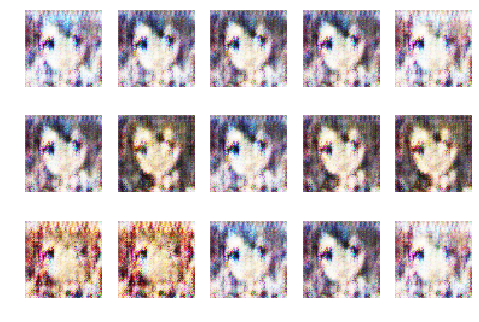

In [ ]:
# In this cell, we generate and visualize 15 images. 
show_imgs(G)

We can see that in this implementation of the VAE-GAN, we got a nice model which can generate images that are clear and of similiar styles with the original images. Our comparison is a subjective one, so one could argue that any of the models we have tried is better than the other. We do see, however, that we seem to have some modal collapse within our VAE-GAN. 

Compared with our DC-GAN, it can create images more robustly and this can be done without extra noise of the anime faces, in orther words, purely. However, the competence of generalization of our model is not very good, it seldom changes the manner or sex of the character, so this is a point that we will try to improve.